In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import random
import warnings
import time
import scipy.stats as stats
from scipy.stats import gaussian_kde
from scipy.stats import lognorm

import gdt.missions.fermi 
import gdt.core 
from gdt.missions.fermi.gbm.finders import TriggerFtp
from gdt.missions.fermi.gbm.localization import GbmHealPix
from gdt.core import data_path
from gdt.core.plot.sky import EquatorialPlot

from ligo.skymap.io import read_sky_map
import ligo.skymap.plot
from astropy.table import Table
from astropy.table import Column
from astropy.io import fits
import astropy_healpix as ah
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

/home/kira/mypy/environments/astroenv/lib/python3.12/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


# read in fermi gbm trigger catalog

In [2]:
from gdt.missions.fermi.gbm.catalogs import BurstCatalog

# initialize burst catalog and list number of rows
burstcat = BurstCatalog()
burstcat.num_rows

Sending request and awaiting response from HEASARC...
Finished in 87 s


3927

In [73]:
# list columns in the burst catalog
burstcat.columns

('NAME',
 'RA',
 'DEC',
 'TRIGGER_TIME',
 'T90',
 'T90_ERROR',
 'T90_START',
 'FLUENCE',
 'FLUENCE_ERROR',
 'FLUX_1024',
 'FLUX_1024_ERROR',
 'FLUX_1024_TIME',
 'FLUX_64',
 'FLUX_64_ERROR',
 'FLNC_BAND_AMPL',
 'FLNC_BAND_AMPL_POS_ERR',
 'FLNC_BAND_AMPL_NEG_ERR',
 'FLNC_BAND_EPEAK',
 'FLNC_BAND_EPEAK_POS_ERR',
 'FLNC_BAND_EPEAK_NEG_ERR',
 'FLNC_BAND_ALPHA',
 'FLNC_BAND_ALPHA_POS_ERR',
 'FLNC_BAND_ALPHA_NEG_ERR',
 'FLNC_BAND_BETA',
 'FLNC_BAND_BETA_POS_ERR',
 'FLNC_BAND_BETA_NEG_ERR',
 'FLNC_SPECTRUM_START',
 'FLNC_SPECTRUM_STOP',
 'PFLX_BEST_FITTING_MODEL',
 'PFLX_BEST_MODEL_REDCHISQ',
 'FLNC_BEST_FITTING_MODEL',
 'FLNC_BEST_MODEL_REDCHISQ',
 'ACTUAL_1024MS_INTERVAL',
 'ACTUAL_256MS_INTERVAL',
 'ACTUAL_64MS_INTERVAL',
 'BACK_INTERVAL_HIGH_START',
 'BACK_INTERVAL_HIGH_STOP',
 'BACK_INTERVAL_LOW_START',
 'BACK_INTERVAL_LOW_STOP',
 'BCAT_DETECTOR_MASK',
 'BCATALOG',
 'BII',
 'DURATION_ENERGY_HIGH',
 'DURATION_ENERGY_LOW',
 'ERROR_RADIUS',
 'FLNC_BAND_DOF',
 'FLNC_BAND_ERGFLNC',
 'FLNC_BAND

In [77]:
print(f'fluence range = {burstcat.column_range('fluence')}')
print(f'FLUX_1024 range = {burstcat.column_range('FLUX_1024')}')
print(f'FLUX_64 range = {burstcat.column_range('FLUX_64')}')
print(f't90 range = {burstcat.column_range('T90')}')
print(f'error radius range = {burstcat.column_range('ERROR_RADIUS')}')

fluence range = (0.0, 0.038836)
FLUX_1024 range = (-0.5465, 2385.0)
FLUX_64 range = (0.0, 3411.57)
t90 range = (0.0, 984.084)
error radius range = (0.0, 68.08)


In [3]:
selected_params = burstcat.get_table(columns=('NAME', 'fluence', 'FLUX_1024', 'FLUX_64', 'T90', 'ERROR_RADIUS'))

In [4]:
#remove bursts with t90 > 2 seconds and localization taken from another instrument
cut_params = selected_params[(selected_params.T90 < 2) & (selected_params.ERROR_RADIUS !=0) & (selected_params.FLUENCE != 0)]

# read in some example skymaps to get actual skymap radius -> error_radius scalar

found that ERROR_RADIUS param in the catalog does not represent the actual skymap size well

In [94]:
from gdt.missions.fermi.gbm.finders import TriggerFtp
from gdt.missions.fermi.gbm.localization import GbmHealPix
from gdt.core import data_path

In [95]:
id_list = [np.char.rstrip(row[0][3:]).tolist() for row in cut_params]

In [96]:
# to look at files for an event 
i=1
trig_finder = TriggerFTP(id_list[i])
skymap_filename = [x for x in trig_finder.files if 'healpix' in x]
print(skymap_filename)

NameError: name 'TriggerFTP' is not defined

In [97]:
class SuppressPlot:
    def __enter__(self):
        plt.ioff()  # Turn off interactive plotting
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        plt.ion()  # Turn on interactive plotting

def get_skymap_a90(grb_id_list, num_objects=False):
    # initialize the trigger data finder to pull from event id
    healpix_finder = TriggerFtp(grb_id_list[1])
    error = []
    filepath_error = []
    areas = []
    i = []
    for index, id in enumerate(grb_id_list):
        #to only process a certain number of objects
        if num_objects:
            if len(areas) >= num_objects:
                break
        try:
            healpix_finder.cd(id)
            # download and open healpix localization data for the event
            healpix_finder.get_healpix(download_dir=data_path.joinpath(id))
            filepath_v00 = data_path.joinpath(f'{id}/glg_healpix_all_bn{id}_v00.fit')
            filepath_v01 = data_path.joinpath(f'{id}/glg_healpix_all_bn{id}_v01.fit')
            
            # Check which file exists
            if filepath_v00.exists():
                filepath = filepath_v00
            elif filepath_v01.exists():
                filepath = filepath_v01
            else:
                filepath_error.append(id)
                continue
            
            with SuppressPlot():
                loc = GbmHealPix.open(filepath)
                a90 = loc.area(0.9)
            areas.append(a90)
            i.append(index)
        except:
            error.append(id)   
    return areas , i, error, filepath_error

start_time = time.time()
areas, indexes, error, filepath_error = get_skymap_a90(id_list)
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

/home/kira/mypy/environments/astroenv/lib/python3.12/site-packages/gdt/core/heasarc.py:253: UserWarning: FTP access to heasarc.gsfc.nasa.gov is unreliable due to high server loads. Users should switch to HTTPS access.
  warnings.warn(


Output()

Output()

Output()

In [23]:
filepath_error

['150312403',
 '101116481',
 '140518709',
 '130804023',
 '121116459',
 '110212550',
 '110517453',
 '170304003',
 '090120627',
 '090927422',
 '140616165',
 '140110411',
 '100719311',
 '090819607',
 '150628767',
 '170827818',
 '090924625',
 '170127067',
 '211124104',
 '161110179',
 '130617564',
 '200126466',
 '120210650',
 '110801335',
 '160829334',
 '121112806',
 '130515056',
 '160513553',
 '090308734',
 '110227009',
 '140605377',
 '150601904',
 '121127914',
 '090412061',
 '080831053',
 '161230298',
 '150923864',
 '150215026',
 '120314412',
 '150301045',
 '120212353',
 '080815917',
 '120701654',
 '090427644',
 '121014638',
 '111103948',
 '090620901',
 '110420946',
 '140329272',
 '150923429',
 '160411062',
 '141230871',
 '100625773',
 '140619490',
 '140710537',
 '170125102',
 '120612687',
 '141128962',
 '110409179',
 '150214293',
 '170726249',
 '081213173',
 '230425230',
 '141031998',
 '171223818',
 '150805746',
 '111022854',
 '090108322',
 '140901821',
 '230306673',
 '140720158',
 '1208

In [25]:
# save results as the above takes a long time to run

df = pd.DataFrame({'Index': indexes, 'Area': areas})
#df.to_csv('gbm_a90_calculations.csv', index=False)

In [6]:
# open results
df = pd.read_csv('gbm_a90_calculations.csv')
indexes = df['Index'].values
areas = df['Area'].values

RMSE: 1758.3455007930265


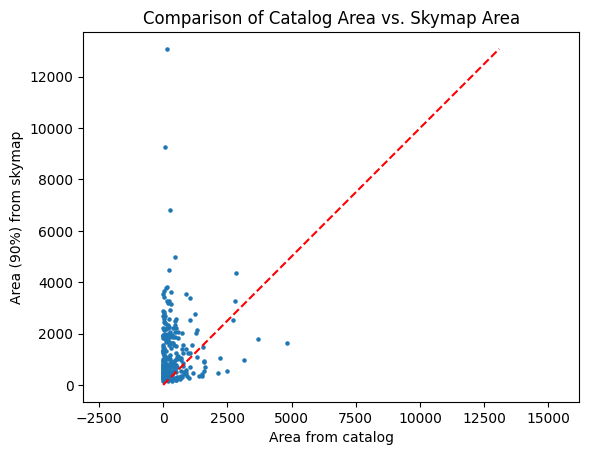

In [9]:
from sklearn.metrics import mean_squared_error

# Assuming error_radius and areas are already defined
error_radius = cut_params['ERROR_RADIUS'][indexes]
error_radius_circle_area = np.pi * error_radius**2

# Scatter plot
plt.scatter(error_radius_circle_area, areas, s=5)
plt.xlabel('Area from catalog')
plt.ylabel('Area (90%) from skymap')
plt.title('Comparison of Catalog Area vs. Skymap Area')
plt.axis('equal')  # Ensure identical scales on both axes

# Plot x=y line
max_val = max(max(error_radius_circle_area), max(areas))
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(error_radius_circle_area, areas))
print(f'RMSE: {rmse}')

plt.show()

RMSE from x=y: 1381.6191769660059


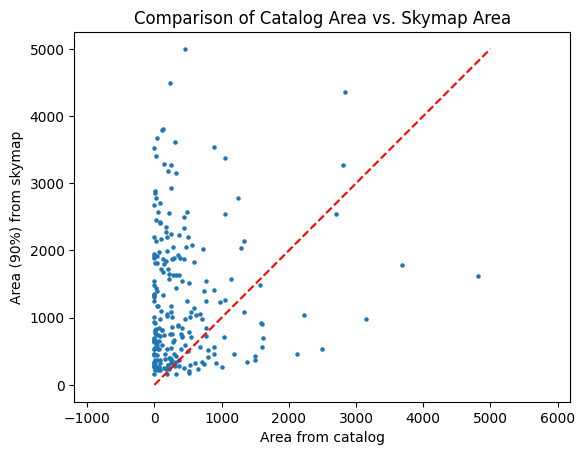

In [8]:
# Assuming error_radius and areas are already defined
error_radius = cut_params['ERROR_RADIUS'][indexes]
error_radius_circle_area = np.pi * error_radius**2

# Filter the data
filtered_indices = (np.array(error_radius_circle_area) < 5000) & (np.array(areas) < 6000)
filtered_error_radius_circle_area = error_radius_circle_area[filtered_indices]
filtered_areas = np.array(areas)[filtered_indices]

# Scatter plot
plt.scatter(filtered_error_radius_circle_area, filtered_areas, s=5)
plt.xlabel('Area from catalog')
plt.ylabel('Area (90%) from skymap')
plt.title('Comparison of Catalog Area vs. Skymap Area')
plt.axis('equal')  # Ensure identical scales on both axes

# # Linear regression for best fit line
# X = filtered_error_radius_circle_area.reshape(-1, 1)
# y = filtered_areas
# reg = LinearRegression().fit(X, y)
# y_pred = reg.predict(X)

# # Plot best fit line
# plt.plot(filtered_error_radius_circle_area, y_pred, color='blue', linestyle='-')

# Plot x=y line
max_val = max(max(filtered_error_radius_circle_area), max(filtered_areas))
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(filtered_error_radius_circle_area, filtered_areas))
print(f'RMSE from x=y: {rmse}')

plt.show()

now use calculated a90 to look for trends with flux, fluence

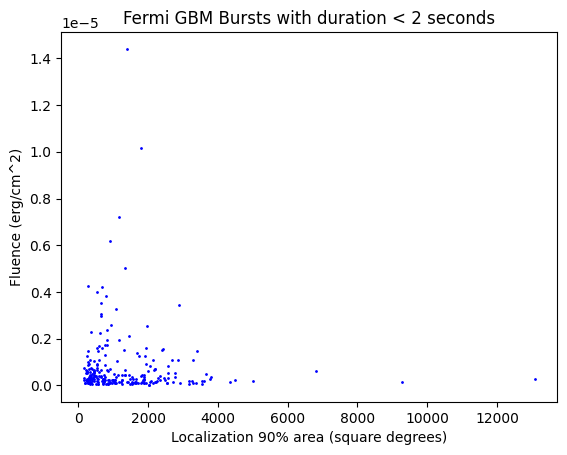

In [7]:
# fluence: flux integrated over the duration of the burst in nominal energy band 10-1000 keV, in erg/cm^2
xplot = areas
yplot = cut_params.FLUENCE[indexes]
plt.scatter(xplot, yplot, color='blue', s=1)
plt.xlabel('Localization 90% area (square degrees)')
plt.ylabel('Fluence (erg/cm^2)')
plt.title('Fermi GBM Bursts with duration < 2 seconds')
plt.show()

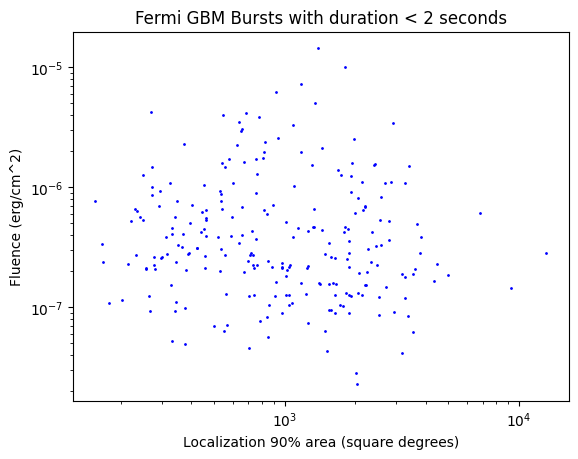

In [10]:
# logarithmic axes above

xplot = areas
yplot = cut_params.FLUENCE[indexes]
plt.scatter(xplot, yplot, color='blue', s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Localization 90% area (square degrees)')
plt.ylabel('Fluence (erg/cm^2)')
plt.title('Fermi GBM Bursts with duration < 2 seconds')
plt.show()

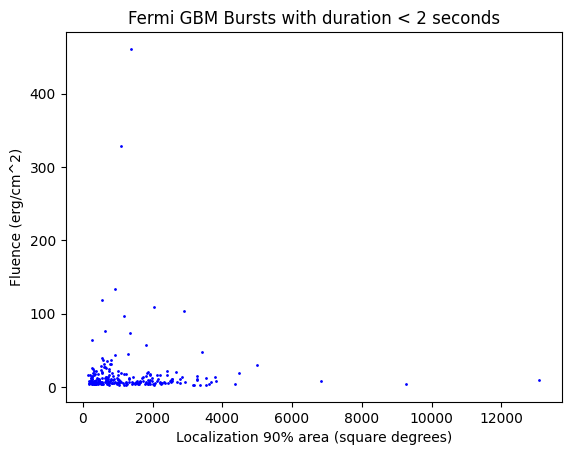

In [11]:
# try Flux

xplot = areas
yplot = cut_params.FLUX_64[indexes]
plt.scatter(xplot, yplot, color='blue', s=1)
plt.xlabel('Localization 90% area (square degrees)')
plt.ylabel('Fluence (erg/cm^2)')
plt.title('Fermi GBM Bursts with duration < 2 seconds')
plt.show()

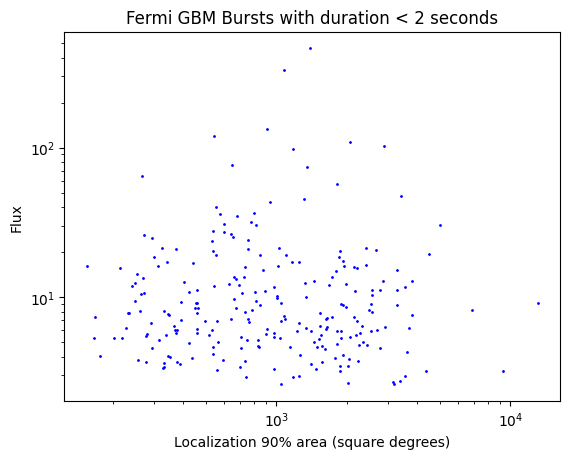

In [12]:
# logarithmic axes above

xplot = areas
yplot = cut_params.FLUX_64[indexes]
plt.scatter(xplot, yplot, color='blue', s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Localization 90% area (square degrees)')
plt.ylabel('Flux')
plt.title('Fermi GBM Bursts with duration < 2 seconds')
plt.show()

# looking for a relationship for skymap size

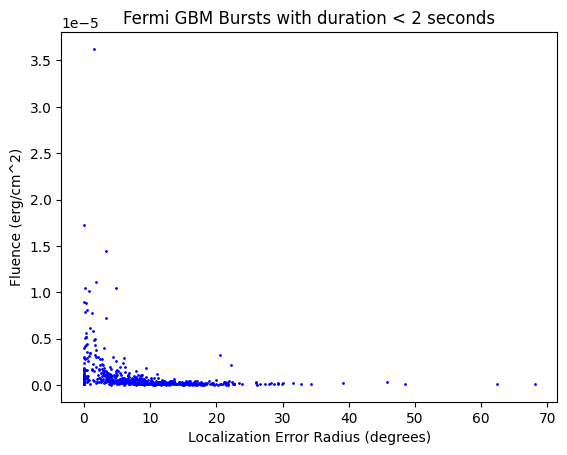

In [13]:
# fluence: flux integrated over the duration of the burst in nominal energy band 10-1000 keV, in erg/cm^2
xplot = cut_params.ERROR_RADIUS
yplot = cut_params.FLUENCE
plt.scatter(xplot, yplot, color='blue', s=1)
plt.xlabel('Localization Error Radius (degrees)')
plt.ylabel('Fluence (erg/cm^2)')
plt.title('Fermi GBM Bursts with duration < 2 seconds')
plt.show()

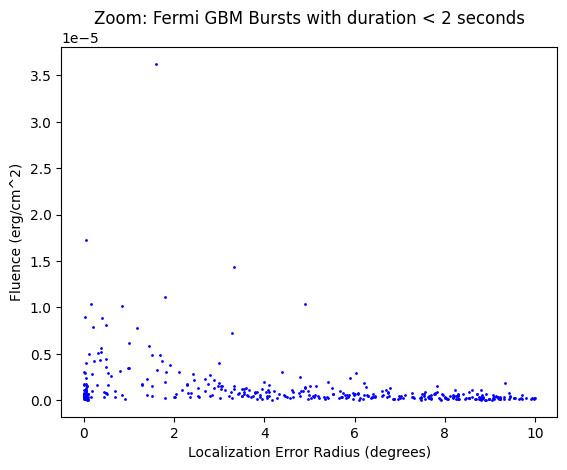

In [14]:
# zoom above

second_cut_params = cut_params[(cut_params.ERROR_RADIUS < 10) & (cut_params.FLUENCE < .001)]
xplot = second_cut_params.ERROR_RADIUS
yplot = second_cut_params.FLUENCE
plt.scatter(xplot, yplot, color='blue', s=1)
plt.xlabel('Localization Error Radius (degrees)')
plt.ylabel('Fluence (erg/cm^2)')
plt.title('Zoom: Fermi GBM Bursts with duration < 2 seconds')
plt.show()

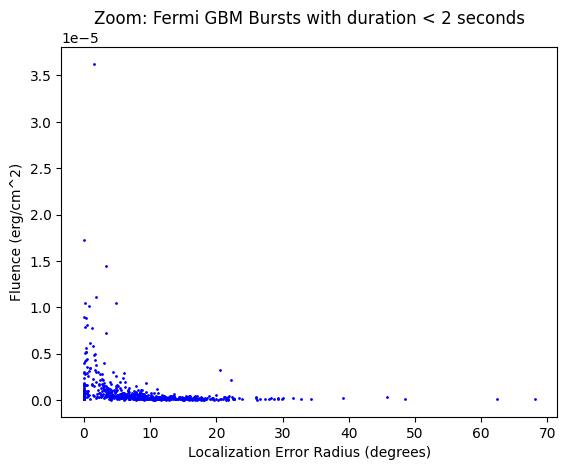

In [15]:
# cut error_radius = 0 which means localization was done with something other than FERMI
# this cuts out 8 / 650 sources so not super important, and I assume the other localization methods could roughly follow trend

third_cut_params = cut_params[cut_params.ERROR_RADIUS != 0]
xplot = third_cut_params.ERROR_RADIUS
yplot = third_cut_params.FLUENCE
plt.scatter(xplot, yplot, color='blue', s=1)
plt.xlabel('Localization Error Radius (degrees)')
plt.ylabel('Fluence (erg/cm^2)')
plt.title('Zoom: Fermi GBM Bursts with duration < 2 seconds')
plt.show()

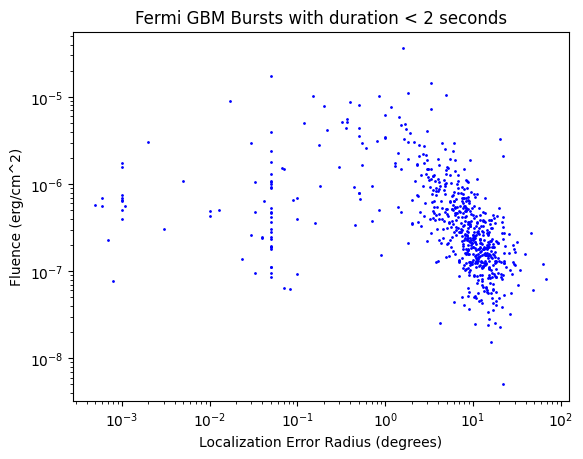

In [16]:
# logarithmic axes above

xplot = cut_params.ERROR_RADIUS
yplot = cut_params.FLUENCE
plt.scatter(xplot, yplot, color='blue', s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Localization Error Radius (degrees)')
plt.ylabel('Fluence (erg/cm^2)')
plt.title('Fermi GBM Bursts with duration < 2 seconds')
plt.show()

using 243 data points from 652


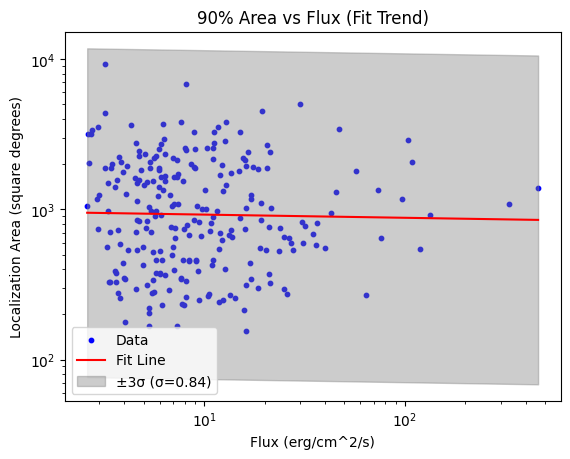

In [17]:
# cut these small localization outliers and fit the cluster to the right
use_error_radius = False
use_a90s = True

# to use the error_radius values
if use_error_radius:
    cut_outliers = cut_params[cut_params.ERROR_RADIUS > 1]
    X = np.log(cut_outliers.FLUENCE).reshape(-1, 1)
    y = np.log(cut_outliers.ERROR_RADIUS)

# to use calculated a90s
if use_a90s:
    X = np.log(cut_params.FLUX_64[indexes]).reshape(-1, 1)
    y = np.log(areas)

model = LinearRegression()
model.fit(X, y)

# Predict values
y_pred = model.predict(X)

# Calculate residuals
residuals = y - y_pred

# Estimate the standard deviation of the residuals
std_dev = np.std(residuals)

# Remove outliers based on residuals
threshold = 3 * std_dev
non_outliers = np.abs(residuals) < threshold
X_no_outliers = X[non_outliers]
y_no_outliers = y[non_outliers]

# Refit the model without outliers
model.fit(X_no_outliers, y_no_outliers)

print(f'using {len(X_no_outliers)} data points from {len(cut_params)}')

# Predict values
y_pred_no_outliers = model.predict(X_no_outliers)

# Calculate new residuals
residuals_no_outliers = y_no_outliers - y_pred_no_outliers

# Estimate the standard deviation of the new residuals
std_dev_no_outliers = np.std(residuals_no_outliers)

# Generate new points to plot +/- one standard deviation
num_points = 100
X_new = np.linspace(X_no_outliers.min(), X_no_outliers.max(), num_points).reshape(-1, 1)
y_fit = model.predict(X_new)
y_upper = y_fit + 3 * std_dev_no_outliers
y_lower = y_fit - 3 * std_dev_no_outliers

# Transform back from log space
X_original = np.exp(X_no_outliers)
X_new_original = np.exp(X_new)
y_fit_original = np.exp(y_fit)
y_upper_original = np.exp(y_upper)
y_lower_original = np.exp(y_lower)

# Plot the original data points without outliers
plt.scatter(X_original, np.exp(y_no_outliers), color='blue', s=10, label='Data')
# Plot the fit line
plt.plot(X_new_original, y_fit_original, color='red', label='Fit Line')
plt.fill_between(X_new_original.squeeze(), y_lower_original, y_upper_original, color='gray', alpha=0.4, label=f'±3σ (σ={std_dev_no_outliers:.2f})')

plt.xscale('log')
plt.yscale('log')
if use_error_radius:
    plt.xlabel('Fluence (erg/cm^2)')
    plt.ylabel('Localization Error Radius (degrees)')
    plt.title('Error Radius vs Fluence (Fit Trend)')
if use_a90s:
    plt.xlabel('Flux (erg/cm^2/s)')
    plt.ylabel('Localization Area (square degrees)')
    plt.title('90% Area vs Flux (Fit Trend)')
plt.legend()
plt.show()

In [21]:
# save model
save = False
if save:
    import joblib
    joblib.dump(model, 'flux_area_fit.pkl')

['flux_area_fit.pkl']

In [18]:
# Find best distribution around fit line: Normal (Gaussian), Student's t, Gamma, Beta, Exponential
distributions = [stats.norm, stats.t, stats.gamma, stats.beta, stats.expon]

warnings.filterwarnings("ignore", category=RuntimeWarning)

# Fit each distribution to the residuals and calculate the goodness of fit
best_distribution = None
best_p_value = 0
for distribution in distributions:
    params = distribution.fit(residuals_no_outliers)
    _, p_value = stats.kstest(residuals_no_outliers, distribution.name, args=params)
    print(f'{distribution.name} p-value: {p_value}')  # Print p-value for each distribution
    if p_value > best_p_value:
        best_p_value = p_value
        best_distribution = distribution

print(f'Best distribution: {best_distribution.name} with p-value: {best_p_value}')

norm p-value: 0.29884693305499854
t p-value: 0.29884971966835416
gamma p-value: 0.2981645865802274
beta p-value: 0.5158952560690686
expon p-value: 1.8904870287091114e-11
Best distribution: beta with p-value: 0.5158952560690686


In [10]:
# function to predict error radius from fluence

def draw_localization_error_radius(fluence):
    """
    Given a fluence value, draw a localization error radius from a Gaussian distribution.
    Parameters:
    fluence (float): The fluence value.
    Returns:
    float: A localization error radius.
    """
    # Log-transform the fluence
    log_fluence = np.log(fluence).reshape(-1, 1)
    
    # Predict the mean log error radius using the model
    mean_log_error_radius = model.predict(log_fluence)
    
    # Fit a beta distribution to the residuals
    a, b, loc, scale = stats.beta.fit(residuals_no_outliers)
    
    # Draw a random log error radius from the beta distribution
    beta_sample = stats.beta.rvs(a, b, loc=loc, scale=scale)
    log_error_radius = mean_log_error_radius + beta_sample

    # Transform back from log space
    error_radius = np.exp(log_error_radius)
    
    return error_radius[0]


def generate_new_fluence_values(fluence, num_new_values):
    kde = gaussian_kde(fluence)
    new_values = []
    min_fluence = np.min(fluence)
    max_fluence = np.max(fluence)
    
    while len(new_values) < num_new_values:
        sampled_values = kde.resample(num_new_values)[0]
        valid_values = sampled_values[(sampled_values >= min_fluence) & (sampled_values <= max_fluence)]
        new_values.extend(valid_values)
    
    return np.array(new_values[:num_new_values])

In [50]:
# function to predict localization area from flux

def draw_localization_area(flux):
    """
    Given a flux value, draw a localization area from a Gamma distribution.
    Parameters:
    flux (float): The flux value.
    Returns:
    float: A localization 90% area.
    """
    # Log-transform the fluence
    log_flux = np.log(flux).reshape(-1, 1)
    
    # Predict the mean log error radius using the model
    mean_log_area = model.predict(log_flux)
    
    # Fit a gamma distribution to the residuals
    shape, loc, scale = stats.gamma.fit(residuals_no_outliers)
    
    # Draw a random log error radius from the gamma distribution
    gamma_sample = stats.gamma.rvs(shape, loc=loc, scale=scale)
    log_area = mean_log_area + gamma_sample

    # Transform back from log space
    area = np.exp(log_area)
    
    return area[0]

def generate_new_flux_values(flux, num_new_values):
    kde = gaussian_kde(flux)
    new_values = []
    min_fluence = np.min(flux)
    max_fluence = np.max(flux)
    
    while len(new_values) < num_new_values:
        sampled_values = kde.resample(num_new_values)[0]
        valid_values = sampled_values[(sampled_values >= min_fluence) & (sampled_values <= max_fluence)]
        new_values.extend(valid_values)
    
    return np.array(new_values[:num_new_values])

In [51]:
if use_error_radius:
    fluence = cut_outliers.FLUENCE
    num_new_values = 400
    fluence_values = generate_new_fluence_values(fluence, num_new_values)

if use_a90s:
    flux = cut_params.FLUX_64[indexes]
    num_new_values = 400
    flux_values = generate_new_flux_values(flux, num_new_values)

In [188]:
def generate_new_fluence_values(fluence, num_new_values, scale_adjustment=1.0):
    # Fit the lognorm distribution to the data
    params = lognorm.fit(fluence)
    
    # Adjust the scale parameter to reduce the tail
    adjusted_params = list(params)
    adjusted_params[-1] *= scale_adjustment
    
    # Generate new values from the adjusted lognorm distribution
    new_values = lognorm.rvs(*adjusted_params[:-2], loc=adjusted_params[-2], scale=adjusted_params[-1], size=num_new_values)
    
    # Ensure values are within the range of the original data
    min_fluence = np.min(fluence)
    max_fluence = np.max(fluence)
    new_values = new_values[(new_values >= min_fluence) & (new_values <= max_fluence)]
    
    # If not enough values are generated, repeat the process until we have enough
    while len(new_values) < num_new_values:
        additional_values = lognorm.rvs(*adjusted_params[:-2], loc=adjusted_params[-2], scale=adjusted_params[-1], size=num_new_values - len(new_values))
        additional_values = additional_values[(additional_values >= min_fluence) & (additional_values <= max_fluence)]
        new_values = np.concatenate([new_values, additional_values])
    
    return new_values[:num_new_values]

fluence = cut_outliers.FLUENCE
num_new_values = 400
scale_adjustment = 1.5 # Adjust this value to control the tail
#fluence_values = generate_new_fluence_values(fluence, num_new_values, scale_adjustment)

In [211]:
def generate_new_fluence_values(fluence, num_new_values, bandwidth=None):
    kde = gaussian_kde(fluence, bw_method=bandwidth)
    new_values = []
    min_fluence = np.min(fluence)
    max_fluence = np.max(fluence)
    
    while len(new_values) < num_new_values:
        sampled_values = kde.resample(num_new_values)[0]
        valid_values = sampled_values[(sampled_values >= min_fluence) & (sampled_values <= max_fluence)]
        new_values.extend(valid_values)
    
    return np.array(new_values[:num_new_values])

fluence = cut_outliers.FLUENCE
num_new_values = 400
bandwidth = .1  # Adjust this value as needed
fluence_values = generate_new_fluence_values(fluence, num_new_values, bandwidth)

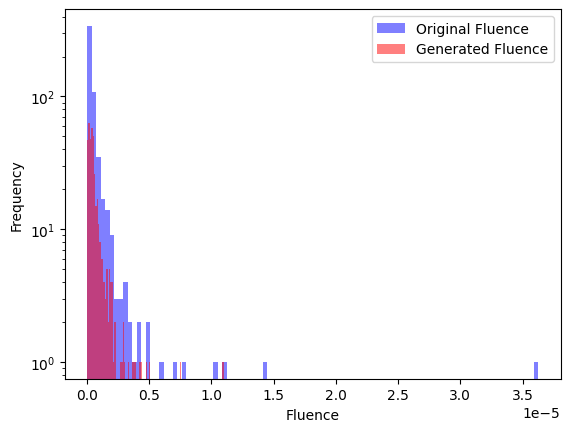

In [212]:
# plot histogram of original fluence and of generated fluence values
plt.hist(fluence, bins=100, color='blue', alpha=0.5, label='Original Fluence')
plt.hist(fluence_values, bins=100, color='red', alpha=0.5, label='Generated Fluence')

plt.yscale('log')
plt.xlabel('Fluence')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [54]:
if use_error_radius:
    # use function to generate 100 samples and plot on top of data
    # Generate 100 samples of fluence values evenly distributed on a logarithmic scale
    fluence_min = cut_outliers.FLUENCE.min()
    fluence_max = cut_outliers.FLUENCE.max()
    #fluence_values = np.logspace(np.log10(fluence_min), np.log10(fluence_max), 400)
    vectorized_draw_error_radius = np.vectorize(draw_localization_error_radius)
    error_radii = vectorized_draw_error_radius(fluence_values)

if use_a90s:
    vectorized_draw_error_radius = np.vectorize(draw_localization_area)
    error_radii = vectorized_draw_error_radius(flux_values)

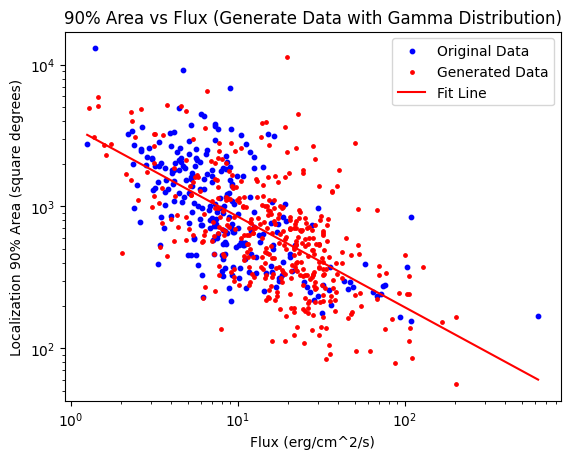

In [55]:
# Plot the original data points without outliers
plt.scatter(X_original, np.exp(y_no_outliers), color='blue', s=10, label='Original Data')
#plot generated data
if use_error_radius:
    plt.scatter(fluence_values, error_radii, label='Generated Data', color='red', s=6)
if use_a90s:
    plt.scatter(flux_values, error_radii, label='Generated Data', color='red', s=6)
# Plot the fit line
plt.plot(X_new_original, y_fit_original, color='red', label='Fit Line')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Fluence (erg/cm^2)')
if use_error_radius:
    plt.xlabel('Fluence (erg/cm^2)')
    plt.ylabel('Localization Error Radius (degrees)')
    plt.title('Error Radius vs Fluence (Generate Data with Beta Distribution)')

if use_a90s:
    plt.xlabel('Flux (erg/cm^2/s)')
    plt.ylabel('Localization 90% Area (square degrees)')
    plt.title('90% Area vs Flux (Generate Data with Gamma Distribution)')

plt.legend()
plt.show()

# looking at other trends

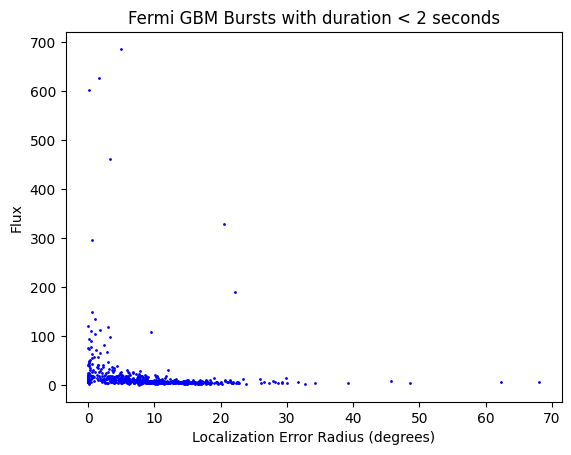

In [39]:
# try Flux_1024 and Flux_64 - peak fluxes in burst, respectively with 1024 ms and 64 ms timescales

xplot = cut_params.ERROR_RADIUS
yplot = cut_params.FLUX_64
plt.scatter(xplot, yplot, color='blue', s=1)
plt.xlabel('Localization Error Radius (degrees)')
plt.ylabel('Flux')
plt.title('Fermi GBM Bursts with duration < 2 seconds')
plt.show()

In [13]:
table = burstcat.get_table(columns=(burstcat.columns))
cat = table[table.T90 < 2]

#get rid of empty space entries which cant be processed
scat_detector_mask = cat['SCAT_DETECTOR_MASK']
scat_detector_mask = np.where(np.char.strip(scat_detector_mask) == '', 0, scat_detector_mask)
scat_detector_mask = scat_detector_mask.astype(int)
cat.SCAT_DETECTOR_MASK = scat_detector_mask #fix this line

In [14]:
# look into the outliers in the log fluence log error radius plot 
nonzero = cat[cat.ERROR_RADIUS  != 0]
print(f'{len(cat)-len(nonzero)} localizations are taken from other experiments')
outliers = nonzero[np.log(nonzero.ERROR_RADIUS) < 1]
print(f'{len(outliers)} have error radius < 1 degrees')
#print(outliers[(outliers.ERROR_RADIUS < 10**-2) & (outliers.ERROR_RADIUS > 10**-4)].ERROR_RADIUS)

8 localizations are taken from other experiments
131 have error radius < 1 degrees


In [15]:
print(f'{len(outliers[outliers.ERROR_RADIUS == 0.05])} have error radius = 0.05 degrees')
print(f'{len(outliers[outliers.ERROR_RADIUS == 0.001])} have error radius = 0.001 degrees')
#degeneracy at 0.05
print(outliers[outliers.ERROR_RADIUS == 0.05])
print(' ')
#degeneracy at 0.001
print(outliers[outliers.ERROR_RADIUS == 0.001])

27 have error radius = 0.05 degrees
8 have error radius = 0.001 degrees
[('GRB090927422                  ', 343.95  , -70.98  , 55101.42172701, 0.512, 0.231, -0.192, 3.0258e-07, 1.8341e-08,  3.319 , 0.2449, -0.256,  6.5443, 1.0933, 0.02453536, 1.167671e-02, 1.167671e-02,  195.2236 ,  69.05154,  69.05154, -0.7267829 , 0.338355  , 0.338355  ,  -9.536743, 2.849994e+04, 2.849994e+04, -0.256, 0.448, 'pflx_plaw                       ', 0.941, 'flnc_plaw                       ', 0.981, 1.024, 0.256, 0.064, 0.94,  7.65,  -4.13, -0.34, '00000000001000', 1, -43.2349, 300., 50., 0.05, 477., 2.267096e-07, 5.112219e-08, 1.436188e-07, 1.766261e-08, 5.932655e-07, 1.337792e-07, 1.673659 , 0.201081  , 0.747984 , 0.08043271,  4.379719, 0.5261994, 1.957364, 0.2104805, 0.982, 1.053, 'Castor C-STAT                   ', 0.02825253, 0.0139483 , 0.0139483 , 478.,  175.8122 ,   41.39108,   41.39108, 2.123749e-07, 4.008891e-08, 1.412441e-07, 1.665167e-08, 5.557537e-07, 1.049068e-07, -0.6377076 , 0.316367  , 0.3

In [20]:
# try mlp to predict error radius
#'PFLX_BEST_FITTING_MODEL' , SCAT_DETECTOR_MASK

X = np.array([cat.FLUENCE, cat.FLUX_64]).T 
y = cat.ERROR_RADIUS

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = MLPRegressor(random_state = 1, max_iter = 10000) 
model.fit(X, y)

MLPRegressor(max_iter=10000, random_state=1)

Mean Squared Error (MSE): 56.525079895378106
R-squared (R²): 0.05036182959875046
Mean Absolute Error (MAE): 5.392353542167037


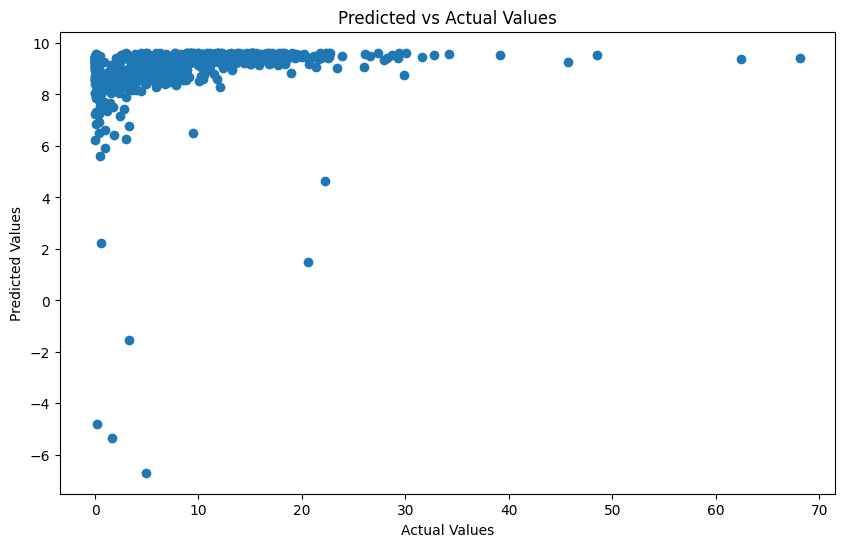

In [21]:
# Make predictions
y_pred = model.predict(X)

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred)
#plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()

# read in existing maps to see what they look like

In [12]:
# initialize the trigger data finder to pull from event 190915240
healpix_finder = TriggerFtp('190915240')

# download and open healpix localization data for the event
healpix_finder.get_healpix(download_dir=data_path.joinpath('190915240'))
filepath = data_path.joinpath('190915240/glg_healpix_all_bn190915240_v00.fit')
loc = GbmHealPix.open(filepath)
print(loc)

/home/kira/mypy/environments/astroenv/lib/python3.12/site-packages/gdt/core/heasarc.py:253: UserWarning: FTP access to heasarc.gsfc.nasa.gov is unreliable due to high server loads. Users should switch to HTTPS access.
  warnings.warn(


Output()

<GbmHealPix: glg_healpix_all_bn190915240_v00.fit
 NSIDE=128; trigtime=590219102.911008;
 centroid=(48.8671875, 4.181528273111476)>


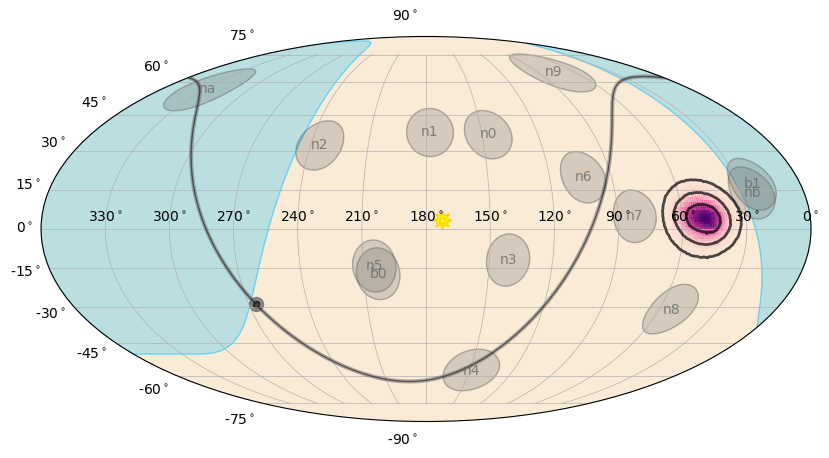

In [13]:
%matplotlib inline

# initialize
skyplot = EquatorialPlot()

# add our healpix localization
skyplot.add_localization(loc)
plt.show()

# simulate skymaps

In [2]:
def simulate_gauss_localization(ra, dec, radius):
    gauss_map = GbmHealPix.from_gaussian(ra, dec, radius)
    return gauss_map

def equatorial_plot(map):
    skyplot = EquatorialPlot()
    skyplot.add_localization(map, detectors=[])
    plt.show()

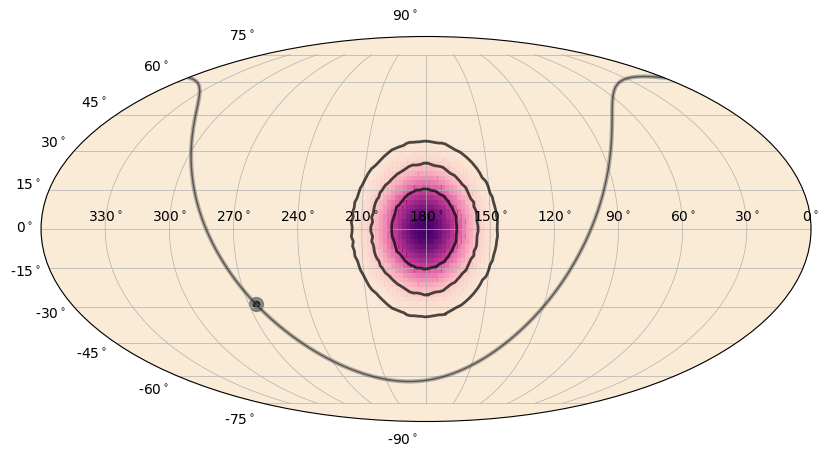

In [9]:
gauss_map = simulate_gauss_localization(180, 0, 10)
equatorial_plot(gauss_map) 

In [4]:
# load some GW skymaps from local directory

def load_skymap_fits(filename, directory):
    filepath = os.path.join(directory, filename)
    with fits.open(filepath) as hdul:
        table = Table.read(hdul)
        return table, hdul

# load gracedb skymaps
directory = '../skymaps/gracedb/'
skymap_load = [load_skymap_fits(file, directory) for file in os.listdir(directory) if file.endswith('.fits')]
skymap_gracedb = [x[0] for x in skymap_load]
hdul_gracedb = [x[1] for x in skymap_load]  
names_gracedb = [os.path.splitext(file)[0] for file in os.listdir(directory) if file.endswith('.fits')]

In [5]:
example_skymap = skymap_gracedb[0]  

# final product

In [6]:
def get_kn_coords(skymap, contour=0.9):
    """
    Given a LIGO skymap, select pixel and get coords to assign as the KN location 
    with a pixel's liklihood of selection reflecting it's probability contained
    """
    skymap.sort('PROBDENSITY', reverse = True)
    level, ipix = ah.uniq_to_level_ipix(skymap['UNIQ']) # ipix = sky location
    nside = ah.level_to_nside(level) # nside = multi-order pixel resolution
    pixel_area = ah.nside_to_pixel_area(ah.level_to_nside(level)) # pixel area in steradians
    prob = pixel_area * skymap['PROBDENSITY']
    cumprob = np.cumsum(prob)
    i = cumprob.searchsorted(contour)
    # skymap90 = skymap[0:i]
    # level90, ipix90 = ah.uniq_to_level_ipix(skymap90['UNIQ']) # ipix = sky location
    # nside90 = ah.level_to_nside(level90) # nside = multi-order pixel resolution
    # pixel_area90 = ah.nside_to_pixel_area(ah.level_to_nside(level90)) # pixel area in steradians
    # prob90 = pixel_area90 * skymap90['PROBDENSITY']
    uniq = skymap['UNIQ']
    kn_uniq = random.choices(uniq, weights=prob, k=1)[0]
    kn_pixel = np.where(skymap['UNIQ'] == kn_uniq)[0][0]
    #print(f'index of KN pixel: {kn_pixel}, probability: {prob[kn_pixel]}')
    lon, lat = ah.healpix_to_lonlat(ipix[kn_pixel], nside[kn_pixel])
    coords = SkyCoord(lon, lat, unit='rad', frame='icrs')
    radec = (coords.ra.deg, coords.dec.deg)
    return radec

def get_GBM_from_GW(gw_skymap):
    %matplotlib agg
    prob_obs = 30 / 360 # jet within 15 degrees of line of sight
    obs_bool = np.random.choice([True, False], p=[prob_obs, 1 - prob_obs])
    if not obs_bool:    
        print('No GBM detection')
        return None, None
    else:
        kn_coords_gw = get_kn_coords(gw_skymap)
        #make GRB skymap template
        radius = np.random.uniform(5, 10)
        gauss_map = GbmHealPix.from_gaussian(100, 0, radius)
        # select kn location in grb skymap taking into account pixel probability
        approx_res = np.sqrt(gauss_map.pixel_area)
        numpts_ra = int(np.floor(0.5*360.0/approx_res))
        numpts_dec= int(np.floor(0.5*180.0/approx_res))
        #probs has dimentions of 98 x 196, ra had 196 elements, dec has 98 elements
        probs, ra, dec = gauss_map.prob_array(numpts_ra = numpts_ra, numpts_dec = numpts_dec)
        flattened_ra = np.tile(ra, len(dec))
        flattened_dec = np.repeat(dec, len(ra))
        coords = zip(flattened_ra, flattened_dec)
        flattened_probs = np.concatenate(probs).ravel()
        select_index = np.arange(0, len(flattened_probs))
        select_pixel_grb = random.choices(select_index, weights=flattened_probs, k=1)[0]
        #translate the GRB skymap so selected pixel lines up with GW kn location
        # given the symmetric gaussian, we can just shift the center of the map
        ra_shift = kn_coords_gw[0] - flattened_ra[select_pixel_grb]
        dec_shift = kn_coords_gw[1] - flattened_dec[select_pixel_grb]
        skymap_grb = GbmHealPix.from_gaussian(ra_shift + 100, dec_shift + 0, radius)
        print(f'coords of KN: {kn_coords_gw}')
        return skymap_grb, kn_coords_gw

In [22]:
skymap_grb, kn_coords = get_GBM_from_GW(example_skymap)

coords of KN: (34.8046875, 7.180755781458282)


In [34]:
def save_skymap_arrays(skymap, filename):
    """
    to save skymap as numpy arrays
    """
    approx_res = np.sqrt(skymap.pixel_area)
    numpts_ra = int(np.floor(0.5*360.0/approx_res))
    numpts_dec= int(np.floor(0.5*180.0/approx_res))
    probs, ra, dec = skymap.prob_array(numpts_ra = numpts_ra, numpts_dec = numpts_dec)
    flattened_ra = np.tile(ra, len(dec))
    flattened_dec = np.repeat(dec, len(ra))
    flattened_probs = np.concatenate(probs).ravel()
    np.savez(f'{filename}.npz', ra=flattened_ra, dec=flattened_dec, probs=flattened_probs)

# Example usage
save_skymap_arrays(skymap_grb, 'test_skymap')

In [47]:
def open_gbm_skymap(filename):
    """
    Function to load skymap arrays from a .npz file
    """
    data = np.load(f'{filename}.npz')
    ra = data['ra']
    dec = data['dec']
    probs = data['probs']
    return ra, dec, probs

ra, dec, probs = open_gbm_skymap('./simulations/GBM_100')

In [43]:
def equatorial_plot(map):
    skyplot = EquatorialPlot()
    skyplot.add_localization(map, detectors=[])
    plt.show()

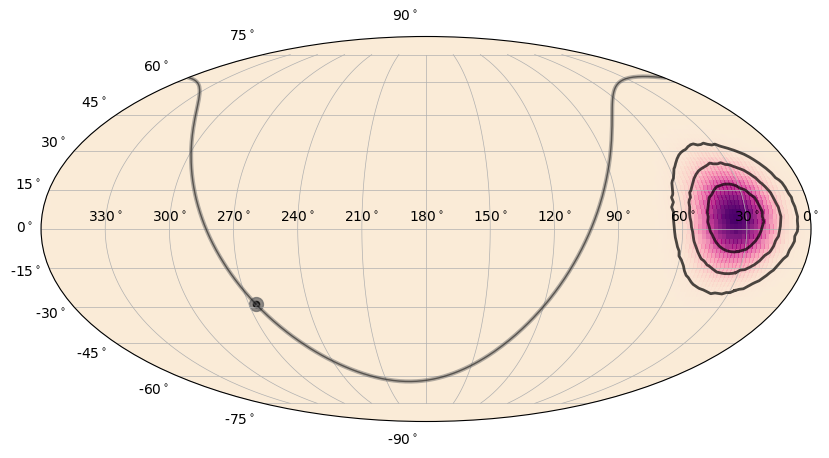

In [44]:
#grb
%matplotlib inline

equatorial_plot(skymap_grb) 

In [45]:
def extract_skymap_data(skymap):
    ring50 = skymap.confidence_region_path(0.5)
    ring90 = skymap.confidence_region_path(0.9)

    approx_res = np.sqrt(skymap.pixel_area)
    numpts_ra = int(np.floor(0.5*360.0/approx_res))
    numpts_dec= int(np.floor(0.5*180.0/approx_res))
    probs, ra, dec = skymap.prob_array(numpts_ra = numpts_ra, numpts_dec = numpts_dec)
    flattened_ra = np.tile(ra, len(dec))
    flattened_dec = np.repeat(dec, len(ra))
    flattened_probs = np.concatenate(probs).ravel()
    return ring50, ring90, flattened_ra, flattened_dec, flattened_probs

In [46]:
def plot_gw_grb(skymap, url, kn_coords):
    ring50, ring90, flattened_ra, flattened_dec, flattened_probs = extract_skymap_data(skymap)
    
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': 'astro degrees mollweide'})
    ax.grid()

    # plot GW skymap
    img = ax.imshow_hpx(url, cmap='cylon')
    # img = ax.imshow_hpx('skymaps/gracedb/S230518h.fits', cmap='cylon')
    
    #plot GRB skymap
    ra50 = [x[0] for x in ring50[0]]
    dec50 = [x[1] for x in ring50[0]]
    ax.plot(ra50, dec50, transform=ax.get_transform('icrs'), c="black")
    ra90 = [x[0] for x in ring90[0]]
    dec90 = [x[1] for x in ring90[0]]
    ax.plot(ra90, dec90, transform=ax.get_transform('icrs'), c="black")

    filtered_indices = np.where(flattened_probs > 0.0001)
    filtered_ra = flattened_ra[filtered_indices]
    filtered_dec = flattened_dec[filtered_indices]
    filtered_probs = flattened_probs[filtered_indices]
    ax.scatter(filtered_ra, filtered_dec, transform=ax.get_transform('icrs'), c=filtered_probs, cmap='plasma', alpha=0.1)

    # Plot the kn_coords
    ax.scatter(kn_coords[0], kn_coords[1], transform=ax.get_transform('icrs'), color='blue', marker='*', s=200)

    plt.show()

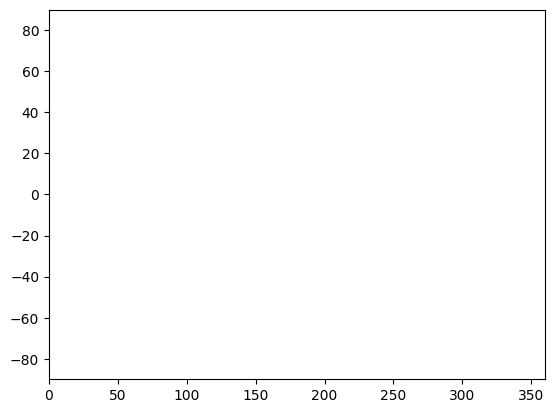

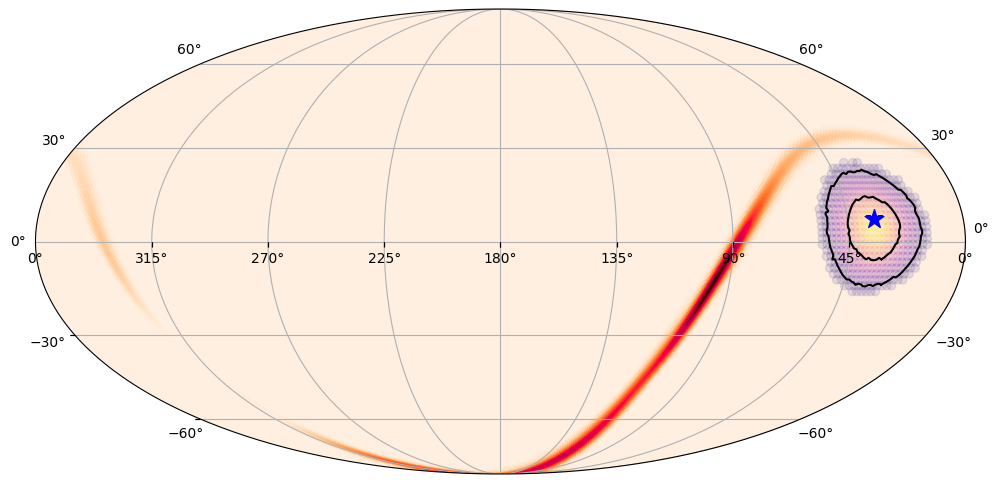

In [47]:
url = 'https://gracedb.ligo.org/api/superevents/S230518h/files/bayestar.fits.gz,1'
skymap = skymap_grb
plot_gw_grb(skymap, url, kn_coords)

In [25]:
# open json
import json

def parse_gw_skymaps(filename):
    with open(filename) as f:
        data = json.load(f)
    contents = data['injections']['content']
    simulation_ids = contents['simulation_id']
    ra = contents['ra']
    dec = contents['dec']
    dl = contents['luminosity_distance']
    return simulation_ids, ra, dec, dl

ids, ra, dec, dl = parse_gw_skymaps('../skymaps/bns1_injection.json')

In [28]:
def draw_localization_radius(flux, model):
    """
    Given a flux value, draw a localization area from a Gamma distribution.
    Parameters:
    flux (float): The flux value.
    Returns:
    float: A localization 90% area.
    """
    log_flux = np.log(flux).reshape(-1, 1)
    mean_log_area = model.predict(log_flux)
    shape, loc, scale = stats.gamma.fit(residuals_no_outliers)
    gamma_sample = stats.gamma.rvs(shape, loc=loc, scale=scale)
    log_area = mean_log_area + gamma_sample
    area = np.exp(log_area)
    radius = (area[0] / (np.pi))**0.5
    return radius

In [41]:
# save residuals no outliers
#np.save('residuals_no_outliers.npy', residuals_no_outliers)

# load residuals no outliers
residuals_no_outliers = np.load('residuals_no_outliers.npy')

In [30]:
def get_gbm_radius(dl):
    """
    Given a luminosity distance, calculate the localization radius for a GBM skymap
    """
    L = 2*10**52 # erg s-1
    flux = L / (4 * np.pi * dl**2)
    radius = draw_localization_radius(flux)
    return radius

In [35]:
get_gbm_radius(dl[3])

6.501359215537876

In [85]:
# open results
df = pd.read_csv('gbm_a90_calculations.csv')
indexes = df['Index'].values
areas = df['Area'].values

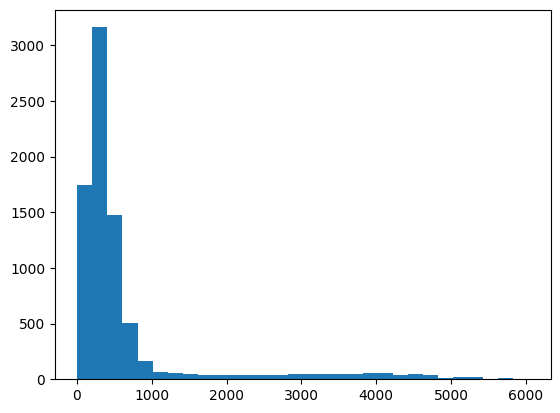

In [91]:
# histogram dl
plt.hist(dl, bins=30)
plt.show()

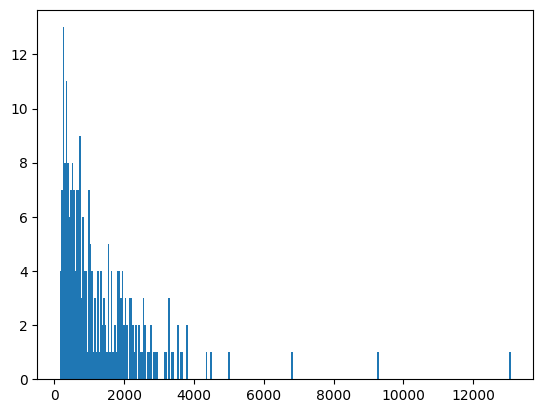

In [32]:
plt.hist(areas, bins = 300)
plt.show()

# EXTRA 

extra code

In [ ]:
# initialize the trigger data finder with a trigger number
trig_finder = TriggerFtp('190114873')
skymap_filename = [x for x in trig_finder.files if 'healpix' in x]
print(skymap_filename)

In [ ]:
# add: read in a handful of events to get a variety of shapes and sizes?
id = '131128629'
# initialize the trigger data finder to pull from event 190915240
healpix_finder = TriggerFtp(id)

# download and open healpix localization data for the event
healpix_finder.get_healpix(download_dir=data_path.joinpath(id))
filepath = data_path.joinpath(f'{id}/glg_healpix_all_bn{id}_v00.fit')
loc = GbmHealPix.open(filepath)
print(loc)

# initialize the trigger data finder to pull from event 190915240
healpix_finder = TriggerFtp(id)

# download and open healpix localization data for the event
healpix_finder.get_healpix(download_dir=data_path.joinpath(id))
filepath = data_path.joinpath('{id}/glg_healpix_all_bn{id}_v00.fit')
loc = GbmHealPix.open(filepath)
print(loc)

# trouble shooting pixel selection bug

In [60]:
# test pixel selection

# generate 100 pixels
results = []

for _ in range(100):
    result = get_kn_coords(example_skymap, contour=0.9)
    results.append(result)

In [61]:
def get_topset(map_path,top_fraction = 0.9):
    skymap = hp.read_map(map_path,nest=False)
    npix = len(skymap)
    nside = hp.npix2nside(npix)
    
    # # Convert to astropy Table, easier for manipulation
    indices = np.arange(len(skymap))
    tm = Table(data=(indices, skymap), names=('id', 'prob'))
    tm.sort('prob')
    cs = np.cumsum(tm['prob'])
    cs.name='cumsum'
    tm.add_column(cs)
    
    top_pix = (tm['cumsum'] > 1 - top_fraction)
    tp = Column(data=top_pix, name="top")
    tm.add_column(tp)
    
    # # Cast as a set for easier comparison below
    top_subset = set(tm['id'][tm['top']])
    return top_subset,nside
    
def in_out(skymap, coords):
    # Read skymap, calculate top pixels    
    top_subset,nside = get_topset(skymap,top_fraction = 0.9)
    ra_obj, dec_obj = coords[0], coords[1]
    inside = False
    pix = hp.ang2pix(nside,ra_obj,dec_obj, lonlat=True)
    if pix in top_subset:
        inside = True 
    return inside

url = 'https://gracedb.ligo.org/api/superevents/S230518h/files/bayestar.fits.gz,1'
inside = [in_out(url, results) for results in results]

In [62]:
inside

[False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False]

In [47]:
# plot

def plot_kn(url, kn_coords):    
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': 'astro degrees mollweide'})
    ax.grid()

    # plot GW skymap
    img = ax.imshow_hpx(url, cmap='cylon')

    # Plot the kn_coords
    ra = [x[0] for x in kn_coords]
    dec = [x[1] for x in kn_coords]
    ax.scatter(ra, dec, transform=ax.get_transform('icrs'), color='blue', s=20)

    plt.show()

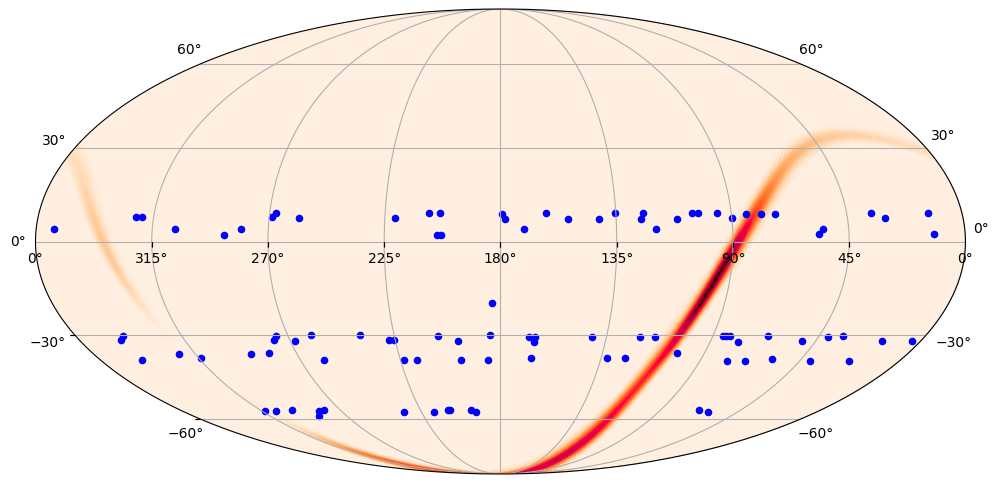

In [48]:
url = 'https://gracedb.ligo.org/api/superevents/S230518h/files/bayestar.fits.gz,1'
plot_kn(url, results)

In [147]:
# account for parts overlapping with earth?

# fraction of localization on Earth
print('Fraction of localization on Earth:',skymap_grb.geo_probability)get_kn_coords(skymap, contour=0.9)

# print percent probability overlaping with gw_skymap and grb_skymap

Fraction of localization on Earth: None


# to get non gaussian shapes:

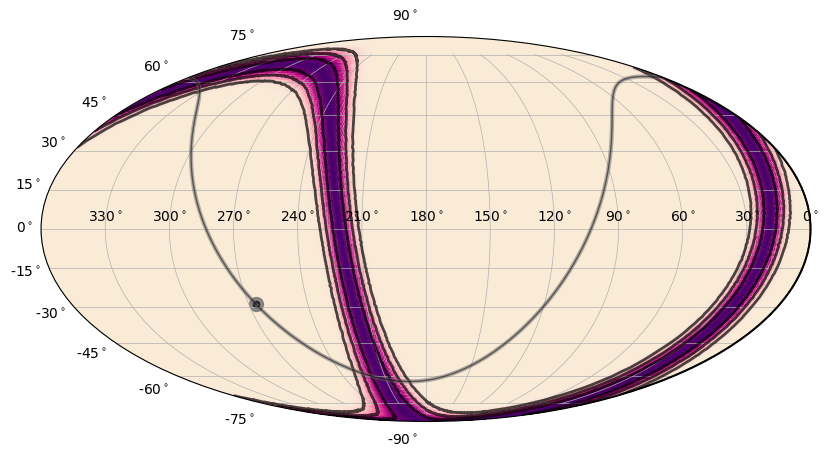

In [7]:
# aternatively: create annulus shaped map given width, radius, and center  

skyplot = EquatorialPlot()

# 3 degree wide annulus with 80 degree radius centered at (ra, dec) = (300, -10)
annulus_map = GbmHealPix.from_annulus(300, -10, 80.0, 3.0)
skyplot.add_localization(annulus_map, detectors=[])

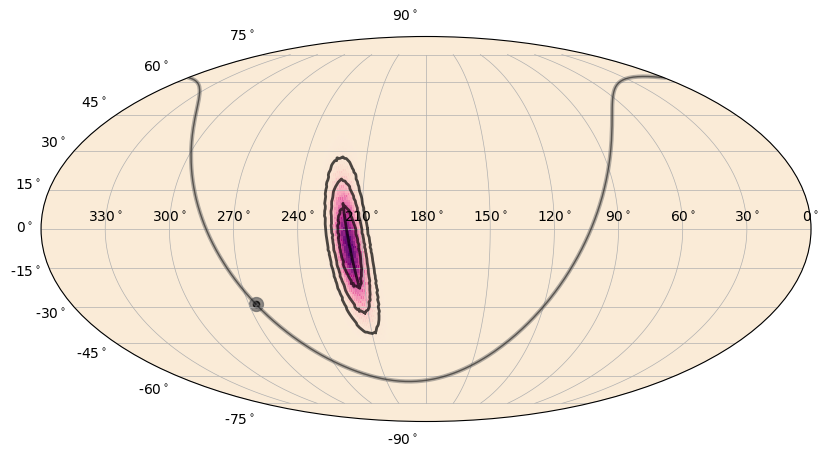

In [8]:
# multiply maps together

skyplot = EquatorialPlot()

# multiply the gaussian map with the annulus map
multiplied = GbmHealPix.multiply(gauss_map, annulus_map)
skyplot.add_localization(multiplied, detectors=[])

In [92]:
def generate_skymap_ellipse():
    gauss_map = GbmHealPix.from_gaussian(180, 0, 10)
    annulus_map = GbmHealPix.from_annulus(300, -10, 80.0, 3.0)
    multiplied = GbmHealPix.multiply(gauss_map, annulus_map)
    return multiplied

def rotate_coords(x, y, centroid):
    angle = np.pi/2
    x_center, y_center = centroid[0], centroid[1]
    #angle = np.random.uniform(0, 2 * np.pi)
    x_translated = x - x_center
    y_translated = y - y_center
    x_rot = np.cos(angle) * x_translated - np.sin(angle) * y_translated   
    y_rot = np.sin(angle) * x_translated + np.cos(angle) * y_translated
    x_rot += x_center
    y_rot += y_center
    return x_rot, y_rot

def transform_coords(gw_skymap, grb_skymap):
    """
    rotation and tranlation
    """
    %matplotlib agg
    ring50, ring90, ra, dec, flattened_probs = extract_skymap_data(grb_skymap)
    
    # rotation
    centroid = grb_skymap.centroid
    ra_rot, dec_rot = rotate_coords(ra, dec, centroid)
    ra50 = [x[0] for x in ring50[0]]
    dec50 = [x[1] for x in ring50[0]]
    ra90 = [x[0] for x in ring90[0]]
    dec90 = [x[1] for x in ring90[0]]
    ra_rot_ring50, dec_rot_ring50 = rotate_coords(ra50, dec50, centroid)
    ra_rot_ring90, dec_rot_ring90 = rotate_coords(ra90, dec90, centroid)

    # translation
    kn_coords_gw = get_kn_coords(gw_skymap)
    select_pixel_grb = random.choices(np.arange(0, len(flattened_probs)), weights=flattened_probs, k=1)[0]
    ra_shift = kn_coords_gw[0] - ra_rot[select_pixel_grb]
    dec_shift = kn_coords_gw[1] - dec_rot[select_pixel_grb]
    ra_rot_trans = ra_rot + ra_shift   
    dec_rot_trans = dec_rot + dec_shift 
    ra_rot_trans_ring50 = ra_rot_ring50 + ra_shift
    dec_rot_trans_ring50 = dec_rot_ring50 + dec_shift
    ra_rot_trans_ring90 = ra_rot_ring90 + ra_shift
    dec_rot_trans_ring90 = dec_rot_ring90 + dec_shift
    ring50_rot_trans =  [[i,j] for i,j in zip(ra_rot_trans_ring50, dec_rot_trans_ring50)]
    ring90_rot_trans =  [[i,j] for i,j in zip(ra_rot_trans_ring90, dec_rot_trans_ring90)]

    return ring50_rot_trans, ring90_rot_trans, ra_rot_trans, dec_rot_trans, flattened_probs, kn_coords_gw

In [106]:
def plot_non_gauss(gw_skymap, grb_skymap, url, kn_coords):
    ring50, ring90, ra, dec, flattened_probs, kn_coords = transform_coords(gw_skymap, grb_skymap)
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': 'astro degrees mollweide'})
    ax.grid()

    # plot GW skymap
    img = ax.imshow_hpx(url, cmap='cylon')
    # img = ax.imshow_hpx('skymaps/gracedb/S230518h.fits', cmap='cylon')

    #plot GRB skymap
    ra50 = [x[0] for x in ring50]
    dec50 = [x[1] for x in ring50]
    ax.plot(ra50, dec50, transform=ax.get_transform('icrs'), c="black")
    ra90 = [x[0] for x in ring90]
    dec90 = [x[1] for x in ring90]
    ax.plot(ra90, dec90, transform=ax.get_transform('icrs'), c="black")

    filtered_indices = np.where(flattened_probs > 0.0001)
    filtered_ra = ra[filtered_indices]
    filtered_dec = dec[filtered_indices]
    filtered_probs = flattened_probs[filtered_indices]
    ax.scatter(filtered_ra, filtered_dec, transform=ax.get_transform('icrs'), c=filtered_probs, cmap='plasma', alpha=0.1)

    # Plot the kn_coords
    ax.scatter(kn_coords[0], kn_coords[1], transform=ax.get_transform('icrs'), color='blue', marker='*', s=200)

    # Show the plot
    plt.show()

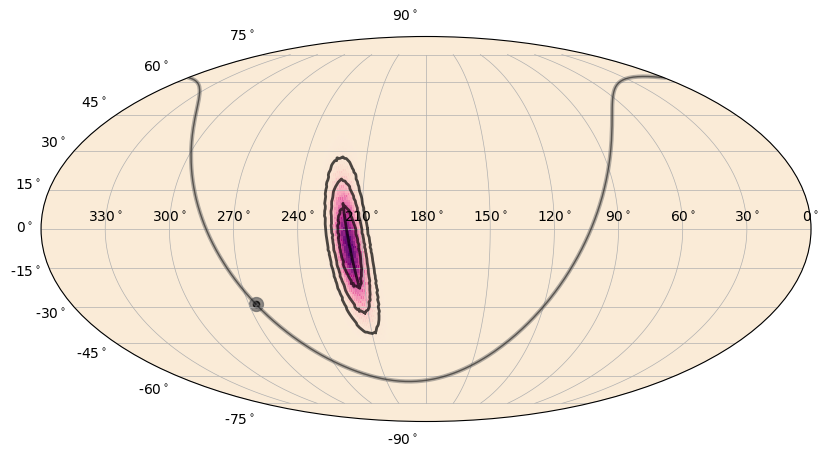

In [107]:
ellipse_map = generate_skymap_ellipse()
equatorial_plot(ellipse_map)

index of KN pixel: 15893, probability: 5.807686825015056e-05


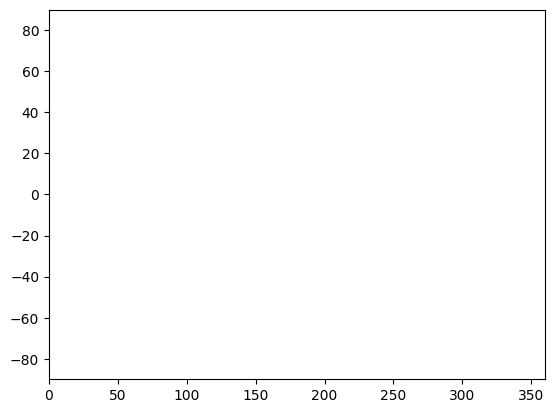

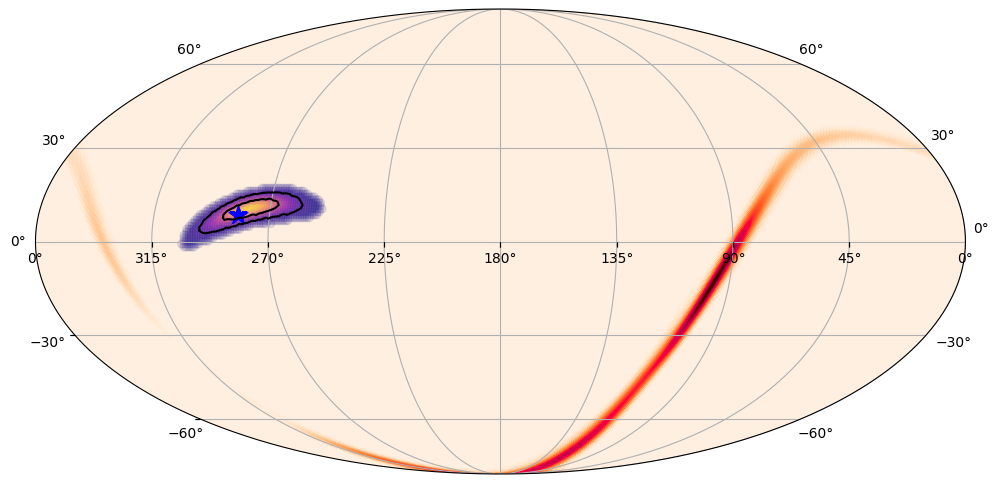

In [108]:
url = 'https://gracedb.ligo.org/api/superevents/S230518h/files/bayestar.fits.gz,1'
skymap = multiplied
plot_non_gauss(example_skymap, multiplied, url, kn_coords)